In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from google.colab import drive
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from math import log, sqrt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from math import log, sqrt
import re
%matplotlib inline
drive.mount('/content/drive')
nltk.download('punkt')

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
dataset = pd.read_csv("/content/drive/My Drive/sms_senior.csv", encoding='latin-1')

In [4]:
dataset.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,say,around,dont,think,back,hey,like,now,send,still,even,friends,per,call,claim,customer,prize,mobile,gonna,home,ive,soon,today,tonight,want,cash,reply,urgent,week,won,...,late,night,someone,guaranteed,service,buy,box,yet,youre,dear,life,people,cos,things,contact,last,went,sent,chat,gud,thk,keep,also,coming,every,told,sleep,care,mins,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


# 1 - Exibir gráfico as palavras mais frequentes em toda a base de dados (Ex.: gráfico de barras, nuvem de palavras, etc).

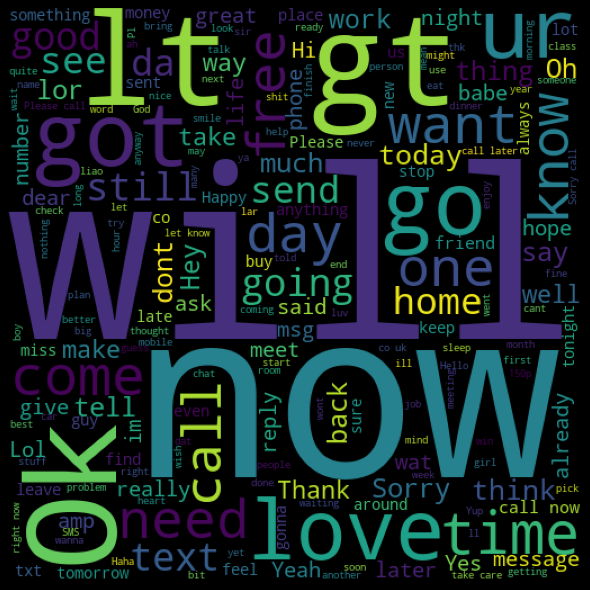

In [5]:
words = ' '.join(list(dataset['Full_Text']))
wc = WordCloud(width = 512, height = 512).generate(words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# 2 - Exibir gráfico com as quantidades de mensagens comuns e spams para cada mês;

In [7]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

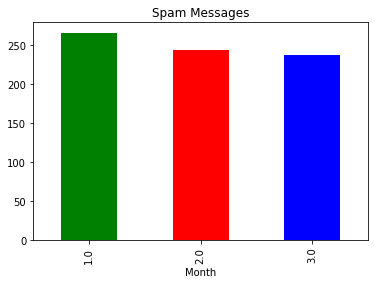

In [8]:
value = dataset.groupby(dataset[dataset['IsSpam'] == 'yes']['Date'].dt.month).size()

value.plot(kind = 'bar',color = ["green","red","blue"], xlabel="Month")

plt.title('Spam Messages')
plt.show();

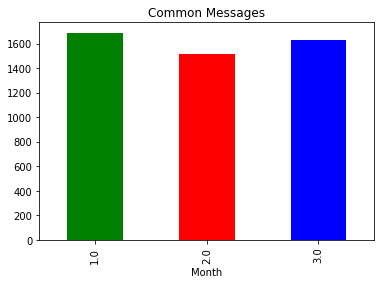

In [9]:
value = dataset.groupby(dataset[dataset['IsSpam'] == 'no']['Date'].dt.month).size()

value.plot(kind = 'bar',color = ["green","red","blue"], xlabel="Month")

plt.title('Common Messages')
plt.show();

# 3 - Calcular o máximo, o mínimo, a média, a mediana, o desvio padrão e a variância da quantidade total de palavras (Word_Count) para cada mês;

In [17]:
grouped = dataset.groupby(dataset['Date'].dt.month).describe()

# Maximo
print("**Maximo** \n", grouped['Word_Count']['max'], "\n")
# Minimo
print("**Minino** \n", grouped['Word_Count']['min'], "\n")
# Média
print("**Média** \n", grouped['Word_Count']['mean'], "\n")
# Mediana
print("**Mediana** \n", dataset.groupby(dataset['Date'].dt.month)['Word_Count'].median(), "\n")
# Desvio padrão
print("**Desvio Padrão** \n", grouped['Word_Count']['std'], "\n")
# Variância
print("**Variância** \n", dataset.groupby(dataset['Date'].dt.month)['Word_Count'].var(), "\n")

**Maximo** 
 Date
1    190.0
2    100.0
3    115.0
Name: max, dtype: float64 

**Minino** 
 Date
1    2.0
2    2.0
3    2.0
Name: min, dtype: float64 

**Média** 
 Date
1    16.336918
2    16.029043
3    16.285255
Name: mean, dtype: float64 

**Mediana** 
 Date
1    13
2    13
3    12
Name: Word_Count, dtype: int64 

**Desvio Padrão** 
 Date
1    12.557171
2    11.042459
3    11.576213
Name: std, dtype: float64 

**Variância** 
 Date
1    157.682535
2    121.935908
3    134.008715
Name: Word_Count, dtype: float64 



# 4 - Exibir o dia de cada mês que possui a maior sequência de mensagens comuns (não spam).

In [18]:
day_month_grouped = dataset[dataset['IsSpam'] == 'no'].groupby([(dataset.Date.dt.month),(dataset.Date.dt.day)]).size()

for x in range(1,4):
    print("***********")
    print("Mês %d" % (x))
    print("Dia com mais mensagens: %d" % day_month_grouped[x].idxmax())
    print("Quantidade: %d" % day_month_grouped[x].max())


***********
Mês 1
Dia com mais mensagens: 1
Quantidade: 69
***********
Mês 2
Dia com mais mensagens: 13
Quantidade: 72
***********
Mês 3
Dia com mais mensagens: 8
Quantidade: 69


# Segunda etapa

In [19]:
dataset['IsSpam'] = dataset['IsSpam'].map({'no': 0, 'yes': 1})

In [20]:
totalMails = dataset['Full_Text'].shape[0]
trainIndex, testIndex = list(), list()
for i in range(dataset.shape[0]) :
  if np.random.uniform(0, 1) < 0.75:
          trainIndex += [i]
  else:
      testIndex += [i]
trainData = dataset.loc[trainIndex]
testData = dataset.loc[testIndex]

In [21]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,say,around,dont,think,back,hey,like,now,send,still,even,friends,per,call,claim,customer,prize,mobile,gonna,home,ive,soon,today,tonight,want,cash,reply,urgent,week,won,...,late,night,someone,guaranteed,service,buy,box,yet,youre,dear,life,people,cos,things,contact,last,went,sent,chat,gud,thk,keep,also,coming,every,told,sleep,care,mins,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,0
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,0
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,1
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,0
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,0


In [22]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,say,around,dont,think,back,hey,like,now,send,still,even,friends,per,call,claim,customer,prize,mobile,gonna,home,ive,soon,today,tonight,want,cash,reply,urgent,week,won,...,late,night,someone,guaranteed,service,buy,box,yet,youre,dear,life,people,cos,things,contact,last,went,sent,chat,gud,thk,keep,also,coming,every,told,sleep,care,mins,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,important information 4 orange user . today is...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,2017-01-01 03:15:00,1
1,I know but you need to get hotel now. I just g...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,33,2017-01-01 04:53:00,0
2,U meet other fren dun wan meet me ah... Muz b ...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,14,2017-01-01 05:26:00,0
3,So can collect ur laptop?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,2017-01-01 08:14:00,0
4,I WILL CAL YOU SIR. In meeting,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2017-01-01 08:48:00,0


In [23]:
trainData['IsSpam'].value_counts()

0    3560
1     552
Name: IsSpam, dtype: int64

In [24]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [25]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.dataset, self.labels = trainData['Full_Text'], trainData['IsSpam']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.dataset.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.dataset[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [26]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [27]:
sc_tf_idf = SpamClassifier(dataset, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['Full_Text'])
metrics(testData['IsSpam'], preds_tf_idf)

Precision:  0.9234449760765551
Recall:  0.9897435897435898
F-score:  0.9554455445544554
Accuracy:  0.987688098495212


In [28]:
sc_bow = SpamClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['Full_Text'])
metrics(testData['IsSpam'], preds_bow)

Precision:  0.8709677419354839
Recall:  0.5538461538461539
F-score:  0.6771159874608151
Accuracy:  0.9295485636114911


In [52]:
pm = process_message('You WIN a year of CDs of Banda calypso just txt CALYPSO to 98177')
sc_tf_idf.classify(pm)

True